<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Growth" data-toc-modified-id="Data-Growth-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Growth</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Normalize-to-reference-conditions" data-toc-modified-id="Normalize-to-reference-conditions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Normalize to reference conditions</a></span></li></ul></div>

<font size="4">This is a template notebook for exploratory analysis on your organism's QC'ed dataset.</font>

In [7]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
sns.set_style('ticks')

# Load data

In [100]:
org_dir = os.path.join('../data/')
os.listdir(org_dir)

['.DS_Store',
 'counts.csv',
 'genomes',
 'log_tpm.csv',
 'log_tpm_norm.csv',
 'log_tpm_qc.csv',
 'metadata',
 'metadata_qc.csv',
 'multiqc_report.html',
 'multiqc_stats.tsv']

In [101]:
DF_metadata = pd.read_csv(os.path.join(org_dir,'metadata_qc.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(org_dir,'log_tpm_qc.csv'),index_col=0)

# Data Growth

In [102]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [103]:
local = DF_metadata.loc[[x for x in DF_metadata.index if x.startswith('Paeru')]]

In [104]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

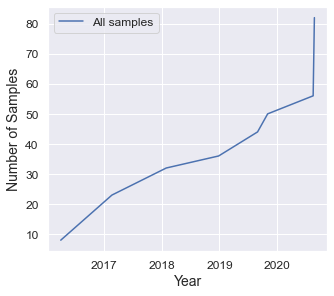

In [105]:
fig,ax = plt.subplots(figsize=(5,5))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax,label='All samples')
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)
plt.legend(fontsize=12)

# Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [106]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  12


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

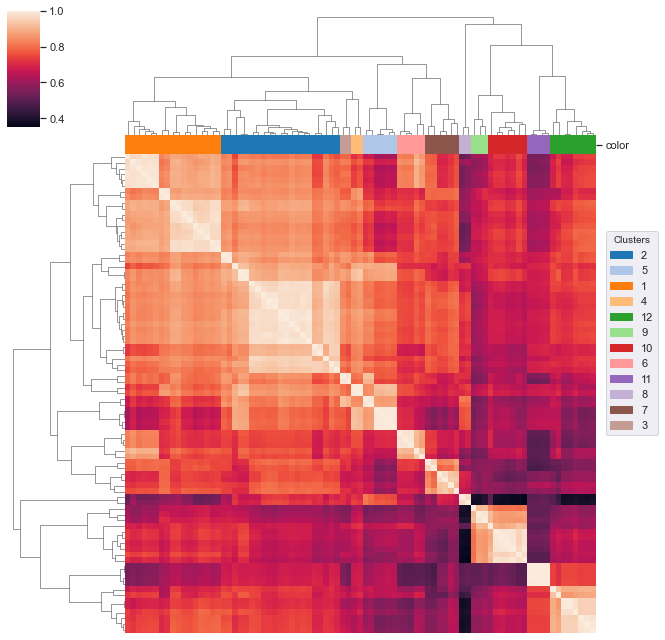

In [107]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [108]:
from sklearn.decomposition import PCA
import numpy as np

<font size="4"> First compute principal components.</font>

In [109]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

<font size="4"> Next, plot the cumulative explained variance</font>

Number of dimensions for 99% of variance: 47


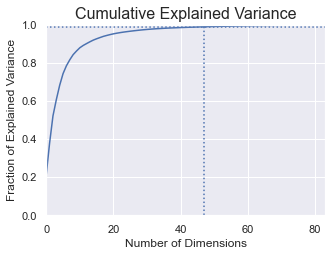

In [110]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

<font size="4">Finally, plot the first two principle components. The following code colors data by Project Name.</font>

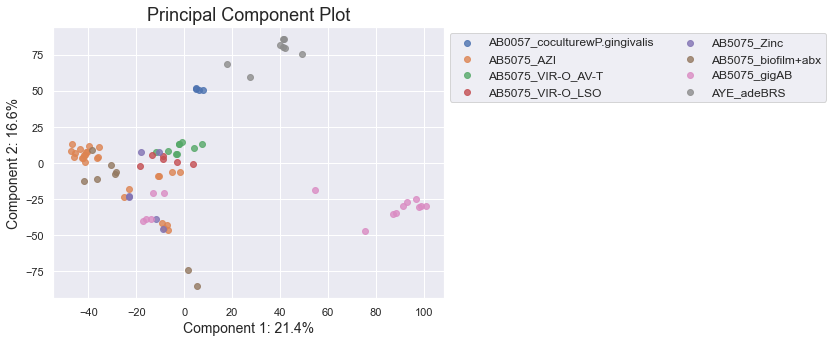

In [111]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project_name'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to reference conditions

In [112]:
project_exprs = []
for name,group in DF_metadata.groupby('project_name'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    assert(ref_cond in group.condition_name.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition_name == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [113]:
DF_log_tpm_norm.head()

,SRX3737104,SRX3737105,SRX3737106,SRX3737107,Abaum_0001,Abaum_0002,Abaum_0003,Abaum_0004,Abaum_0005,Abaum_0006,...,SRX2568062,SRX2568063,ERX1215168,ERX1215173,ERX1221046,ERX1221048,ERX1221049,ERX1221050,ERX1221052,ERX1221053
Geneid,,,,,,,,,,,,,,,,,,,,,
ABUW_6001,0.000000,0.000000,0.000000,0.000000,0.995209,0.890650,1.026435,0.857228,0.630393,1.686921,...,-0.161644,0.161644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABUW_6002,0.000000,0.000000,0.000000,0.000000,0.584653,0.549880,1.419116,0.737354,0.808984,0.641322,...,0.789251,-0.789251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABUW_6003,0.000000,0.000000,0.000000,0.000000,-0.527902,0.471622,0.814006,0.200051,-0.172408,0.926828,...,0.243876,-0.243876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ABUW_5001,0.136507,-0.013648,0.068553,-0.191413,0.143318,0.323239,0.601085,0.880182,1.470372,1.161976,...,0.213505,-0.213505,0.674989,1.054121,-0.225109,-0.214648,-0.235231,-0.557799,0.298318,0.337103
ABUW_5002,0.107672,-0.039992,0.013536,-0.081216,0.101036,0.323650,-0.047249,0.460070,0.692154,0.832797,...,-0.363506,0.363506,1.163134,0.572695,-0.355785,-0.221197,-0.586152,-0.903144,0.169034,0.089788


<font size=4>Uncomment this code to save the log_tpm_norm file</font>

In [114]:
DF_log_tpm_norm.to_csv(path.join(org_dir,'log_tpm_norm.csv'))

Text(0, 0.5, 'sigD Activity')

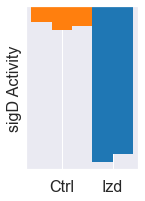

In [115]:
fig,ax = plt.subplots(figsize=(2,3))
plt.bar(range(5),[-2,-3,-2.6,-20,-19],width=1,linewidth=0,color=['tab:orange']*3+['tab:blue']*2)
plt.xticks([1,3.5],labels=('Ctrl','Izd'),fontsize=16)
plt.yticks([])
plt.ylabel('sigD Activity',fontsize=16)

# Expression Variation

(array([ 47., 440., 938., 917., 677., 389., 203., 136.,  73.,  40.,  18.,
          8.,   5.,   2.,   2.]),
 array([0.31436426, 0.55477853, 0.7951928 , 1.03560707, 1.27602134,
        1.5164356 , 1.75684987, 1.99726414, 2.23767841, 2.47809268,
        2.71850695, 2.95892122, 3.19933549, 3.43974975, 3.68016402,
        3.92057829]),
 <BarContainer object of 15 artists>)

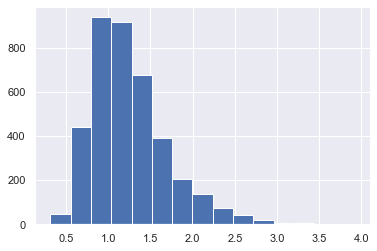

In [116]:
plt.hist(DF_log_tpm_norm.std(axis=1),bins=15)

Text(0, 0.5, 'Standard Deviation')

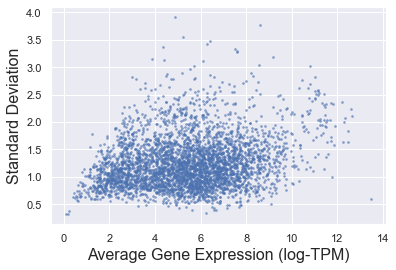

In [117]:
# Plot of average expression against standard deviation of expression (normalized within each project)
plt.scatter(DF_log_tpm.mean(axis=1),DF_log_tpm_norm.std(axis=1),s=3,alpha=0.5)
plt.xlabel('Average Gene Expression (log-TPM)',fontsize=16)
plt.ylabel('Standard Deviation',fontsize=16)